In [1]:
import os, sys
sys.path.insert(1, '../dataset')
import data_preparation
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#prepare data
if not os.path.exists('../dataset/prepared'):
    os.makedirs('../dataset/prepared')
data_preparation.to_csv('../dataset/atepc/restaurants_test.csv', '../dataset/prepared/restaurants_test.csv',)
data_preparation.to_csv('../dataset/atepc/restaurants_train.csv', '../dataset/prepared/restaurants_train.csv',)

In [3]:
#load
data = pd.read_csv('../dataset/prepared/restaurants_train.csv')
data_test = pd.read_csv('../dataset/prepared/restaurants_test.csv')

In [4]:
# remove duplicates
def remove_duplicates(data):
    d = data
    rows_drop = []
    for i in range(1,len(d)):
        if d['Tokens'][i] == d['Tokens'][i-1]:
            #sum tags
            tags1 = np.array(d['Tags'][i].strip('][').split(', '), dtype=np.int)
            tags2 = np.array(d['Tags'][i-1].strip('][').split(', '), dtype=np.int)
            pol1 = np.array(d['Polarities'][i].strip('][').split(', '), dtype=np.int)
            pol2 = np.array(d['Polarities'][i-1].strip('][').split(', '),   dtype=np.int)
            tags = tags1+tags2
            tags[tags>1] = 1
            pol = pol1+pol2
            pol[pol>1] = 1
            pol[pol<-1] = -1
            d['Tags'][i] = str([t for t in tags])
            d['Polarities'][i] = str([p for p in pol])
           
            rows_drop.append(i)
            i-=1
    d = d.drop(d.index[rows_drop])
    d.index = range(len(d))
    return d
data_test = remove_duplicates(data_test)
data = remove_duplicates(data)

# ABTE

In [5]:
from transformers import BertTokenizer
import torch
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
from abte import ABTEModel
from utils import tag_to_word, tag_to_word_df

In [6]:
# from abte import ATEModel
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ABTEModel(tokenizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
model.train(data, batch_size=246, lr=1e-4, epochs=4, device=DEVICE)

epoch: 0	batch: 1/8	loss: 0.9757346510887146	batch time: 194.486	total time: 194.486
epoch: 0	batch: 2/8	loss: 0.24299487471580505	batch time: 123.097	total time: 317.58299999999997
epoch: 0	batch: 3/8	loss: 0.20397233963012695	batch time: 145.623	total time: 463.20599999999996
epoch: 0	batch: 4/8	loss: 0.14630894362926483	batch time: 180.371	total time: 643.577
epoch: 0	batch: 5/8	loss: 0.13930600881576538	batch time: 178.977	total time: 822.554


In [ ]:
N=100
nepochs = 4
test_accuracy, test_pred, test_targets = model.test(data_test[:N], batch_size=256, lr=1e-4, epochs=nepochs)

# Plot hystory and accuracy

In [ ]:
test_tags_real = [t.strip('][').split(', ') for t in data_test['Tags'][:N]]
test_tags_real = [[int(i) for i in t] for t in test_tags_real]
test_pred_string = [''.join(str(i) for i in p) for p in test_pred]
ABTE_data = tag_to_word_df(data_test[:N], 'gold terms', test_tags_real)
ABTE_data = tag_to_word_df(ABTE_data, 'pred terms', test_pred)
ABTE_data['predicted_tags'] = test_pred_string

In [ ]:
ABTE_data.head(5)

,Tokens,Tags,Polarities,gold terms,pred terms,predicted_tags
0,"['The', 'bread', 'is', 'top', 'notch', 'as', '...","[0, 1, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0, 0]",[bread],[bread],01000000
1,"['I', 'have', 'to', 'say', 'they', 'have', 'on...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]","[delivery, times]",[delivery],0000000000100000
2,"['Food', 'is', 'always', 'fresh', 'and', 'hot'...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",[Food],[eat],00000000010
3,"['Did', 'I', 'mention', 'that', 'the', 'coffee...","[0, 0, 0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 1, 0, 0, 0]",[coffee],[coffee],000001000
4,"['Certainly', 'not', 'the', 'best', 'sushi', '...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[place],"[sushi, in, is]",00001100000000000001000000
5,"['I', 'trust', 'the', 'people', 'at', 'Go', 'S...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",[people],[],00000000000000000
6,"['Straight', '-', 'forward', ',', 'no', 'surpr...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]","[Japanese, food]","[Japanese, food]",000000000110
7,"['BEST', 'spicy', 'tuna', 'roll', ',', 'great'...","[0, 0, 0, 0, 0, 0, 1, 1, 0]","[0, 0, 0, 0, 0, 0, 1, 1, 0]","[asian, salad]","[spicy, tuna, roll, asian, salad]",011100110
8,"['Try', 'the', 'rose', 'roll', '-', 'LRB', '-'...","[0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[rose, roll, menu]","[rose, roll, -]",0011000000100000
9,"['I', 'love', 'the', 'drinks', ',', 'esp', 'ly...","[0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[drinks, lychee, martini, food]","[drinks, esp, lychee, martini, ,, and, the, VERY]",00010111111000100000


## Draw clouds

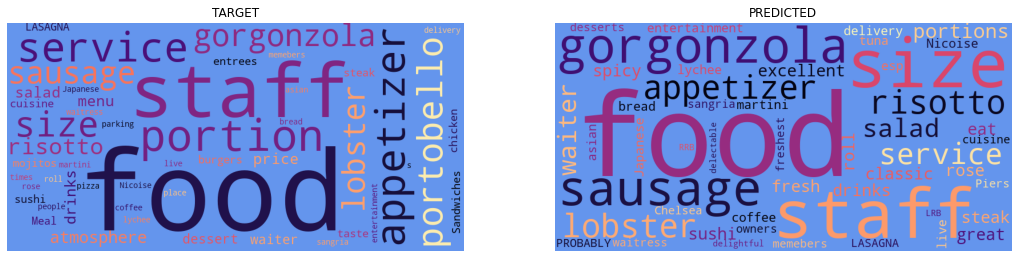

In [ ]:
def generate_wordcloud(text):
    """
    Generate word cloud images.
    """
    from wordcloud import WordCloud
    wordcloud = WordCloud(collocations=False,  width=800, height=400,
                          background_color="cornflowerblue", colormap="magma",
                          max_words=50).generate(text)
    return wordcloud

def target_predicted_wordcloud(target, predicted, img_name):
    """
    gets two lists of words and generates a wordcloud for each
    """
    targets_words = []
    predicted_words = []
    for t in target:
        for w in t:
            targets_words.append(w)
    for t in predicted:
        for w in t:
            predicted_words.append(w)
    targets_text = ' '.join(targets_words)
    predicted_text = ' '.join(predicted_words)
    targets_wordcloud = generate_wordcloud(targets_text)
    predicted_wordcloud = generate_wordcloud(predicted_text)

    fig, ax = plt.subplots(1,2,figsize=(18,10))
    ax[0].imshow(targets_wordcloud), ax[1].imshow(predicted_wordcloud)
    ax[0].set_title("TARGET"), ax[1].set_title("PREDICTED")
    ax[0].axis("off"), ax[1].axis("off")
    fig.savefig(img_name+".pdf", bbox_inches="tight")
    
target_predicted_wordcloud(ABTE_data['gold terms'].values, ABTE_data['pred terms'].values, "extracted_terms_wordcloud.pdf")